Results from SCARGC algorithm (for boxplot and accuracy timelime).
Five Classes Vertical Translation. Bidimensional.
Stream mode with pool size = 300



METHOD: Static knn as classifier
Execution time:  6.409856
Average error: 55.5574
Average micro-F1: 0.4413
Average Accuracy:  44.4426
Standard Deviation:  18.8218048879
Variance:  354.26033924


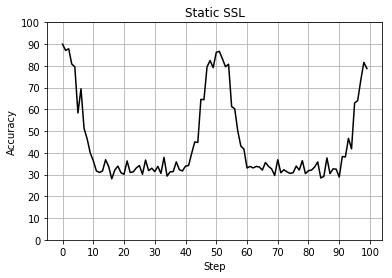

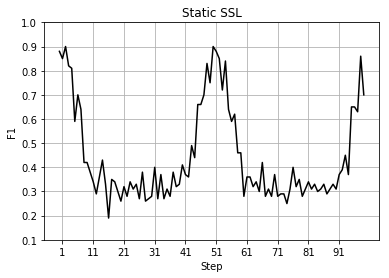




METHOD: Sliding knn as classifier


C:\Users\raul\Desktop\GITHUB\Systems-Engineering\Dissertation\source\classifiers.py:135: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return KNeighborsClassifier(n_neighbors=K, algorithm = 'brute').fit(X, y)


Execution time:  6.550950320987654
Average error: 62.425
Average micro-F1: 0.37270000000000003
Average Accuracy:  37.575
Standard Deviation:  13.102306629
Variance:  171.670439


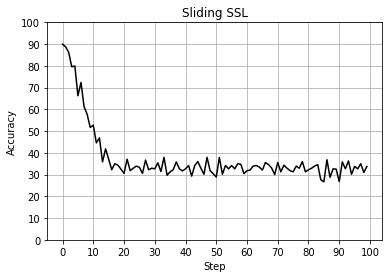

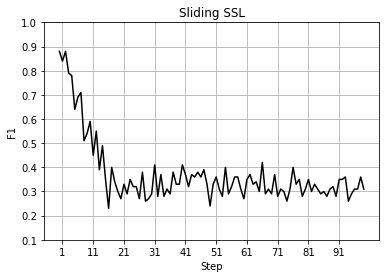




METHOD: knn as classifier and kde as core support extraction with cutting data method
Execution time:  6.531484839506174
Average error: 41.0157
Average micro-F1: 0.5883
Average Accuracy:  58.9843
Standard Deviation:  7.57186004295
Variance:  57.33306451


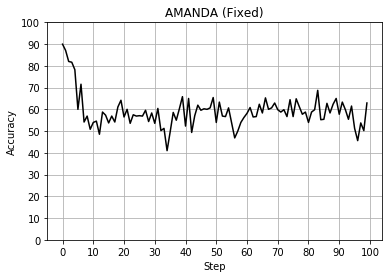

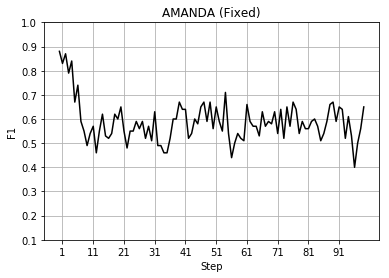




METHOD: knn as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  6.7768509629629605
Average error: 58.5867
Average micro-F1: 0.41540000000000005
Average Accuracy:  41.4133
Standard Deviation:  23.9924667783
Variance:  575.63846211


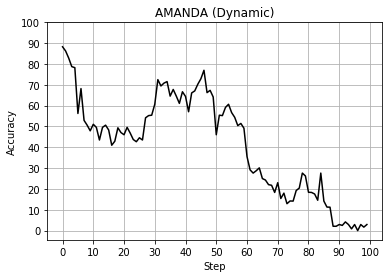

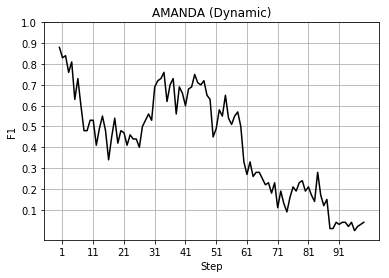




Method: SCARGC
Execution time:  6.7768509629629605
Average micro-F1: 0.18729999999999997
Average Accuracy:  86.4331241283
Standard Deviation:  1.98394444785
Variance:  3.93603557215


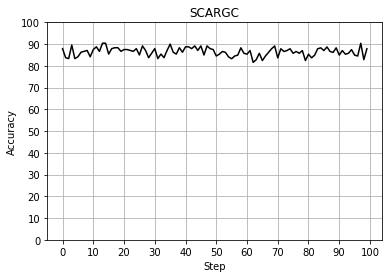

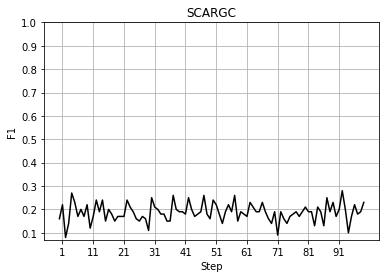

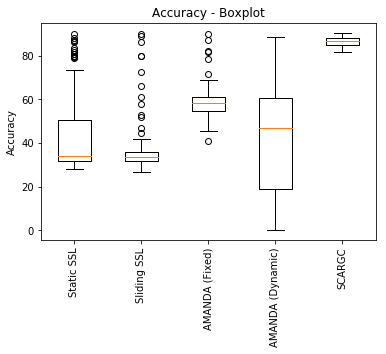

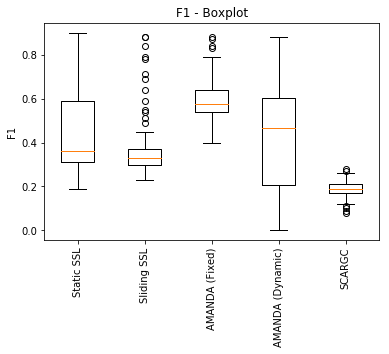

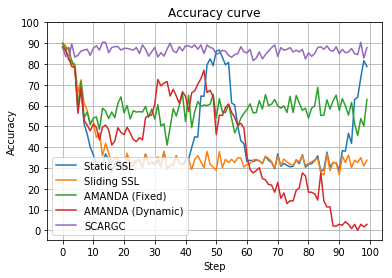

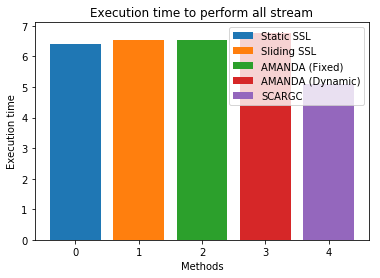

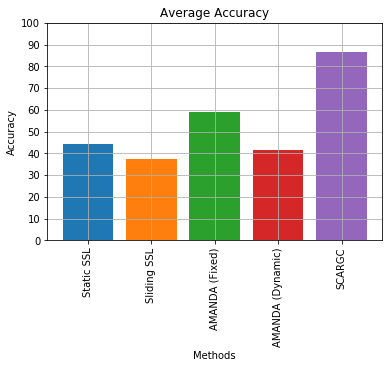

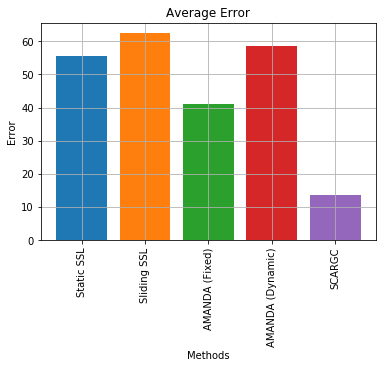

Error reduction: -15.4527412888
Error reduction: 32.7201828876
Error reduction: -6.81620787263
Error reduction: 94.4826003166


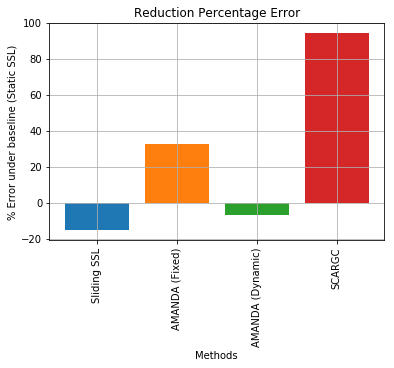

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN
import numpy as np



class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K

        
def accSCARGC(path, sep, key, steps):
    resultsSCARGC_1, resultsSCARGC_2 = setup.loadSCARGCBoxplotResults(path, sep)
    results = resultsSCARGC_1[key]
    res = [ results[i::steps] for i in range(steps) ]
    arrAcc = []
    for i in range(steps):
        arrAcc.append(sum(res[i])/len(res[i])*100)
    return arrAcc, results


#only for binary classification
def labelSCARGC(resultsSCARGC, true_labels):
    predictions = []
    true_labels = np.array(true_labels)
    true_labels = true_labels.flatten()
    #print(true_labels)
    for i in range(len(true_labels)):
        if resultsSCARGC[i] == 1:
            predictions.append(true_labels[i])
        else:
            if true_labels[i] == 0:
                predictions.append(1)
            else:
                predictions.append(0)
    return predictions


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'knn' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = 300
    isBatchMode = False # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load5CVT(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = 50 #int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 9, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 9, clfName=sslClassifier)
    
    # Incremental SSL
    #experiments[2] = Experiment(incremental_LN, 5, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 9, 0.85, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    #experiments[5] = Experiment(scargc_1NN, 5) 
    arrAccSCARGC, predictionsSCARGC = accSCARGC(path, sep, '5CVT', steps)
    #predictionsSCARGC = labelSCARGC(predictionsSCARGC, dataLabels[labeledData:])
    arrPredictionsSCARGC = [ predictionsSCARGC[i::steps] for i in range(steps) ]
    externalResults.append({"name":"SCARGC", "predictions":arrPredictionsSCARGC, "accuracies":arrAccSCARGC, "time":5.1037})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()